In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# XGBoost Baseline, no NAICS
XGBoost model, but without NAICS features.  Do XGBoost model tuning which will be reused in other scripts.  Also, look at variance in scores

For this baseline only, I run repeated models to get an idea of the variance of metrics

*This script takes about 10 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle, importlib, random

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.inspection import permutation_importance
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_xgboost

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [7]:
train_df = sba_loans[sba_loans['dset'] == 'train'].copy()
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

In [8]:
train_df.shape

(425594, 50)

In [9]:
train_df.drop_duplicates('LoanNr_ChkDgt').shape

(425594, 50)

#### Set the predictor features.  No NAICS-related features at this stage.
Base features only

In [10]:
predictor_features = setup.predictor_features 
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag']


In [11]:
train_df[predictor_features].describe()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag
count,425594.000000,425594.000000,422477.000000,4.255940e+05,425050.000000,342255.000000,425594.000000
mean,9.758920,2.172277,0.097807,1.949280e+05,0.279906,0.814930,0.050858
std,63.011166,15.140139,0.297053,2.994808e+05,0.448953,0.388355,0.219709
min,0.000000,0.000000,0.000000,4.000000e+03,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,3.600000e+04,0.000000,1.000000,0.000000
50%,4.000000,0.000000,0.000000,9.000000e+04,0.000000,1.000000,0.000000
75%,9.000000,2.000000,0.000000,2.157000e+05,1.000000,1.000000,0.000000
max,9992.000000,5621.000000,1.000000,1.144632e+07,1.000000,1.000000,1.000000


In [12]:
train_df[predictor_features + ['target']].corr()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,target
NoEmp,1.000000,0.052510,-0.009243,0.093125,-0.038672,0.002058,0.006517,-0.027838
CreateJob,0.052510,1.000000,-0.046967,0.101755,0.028831,0.009019,0.036918,-0.009540
LowDoc,-0.009243,-0.046967,1.000000,-0.133731,0.154037,-0.119292,0.039258,-0.076836
DisbursementGross,0.093125,0.101755,-0.133731,1.000000,-0.067410,-0.006023,0.082087,-0.122857
new_business,-0.038672,0.028831,0.154037,-0.067410,1.000000,-0.046626,0.136142,0.014277
urban_flag,0.002058,0.009019,-0.119292,-0.006023,-0.046626,1.000000,-0.004093,0.054391
franchise_flag,0.006517,0.036918,0.039258,0.082087,0.136142,-0.004093,1.000000,-0.011047
target,-0.027838,-0.009540,-0.076836,-0.122857,0.014277,0.054391,-0.011047,1.000000


In [13]:
with open(Path(setup.temp_path).joinpath('03_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Hyperparameter Tune and Fit

In [14]:
mean_target = np.mean(train_df['target'])
scale_pos_wt = (1-mean_target)/mean_target
print(f'target rate: {mean_target}, pos wt: {scale_pos_wt}')

target rate: 0.20307382152943884, pos wt: 3.9243176322214124


In [15]:
importlib.reload(sg_xgboost)

<module 'sba_gnn.sba_gnn.sg_xgboost' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_xgboost.py'>

##### Simple hyperparameter search

In [16]:
best_params = sg_xgboost.hyperparameter_tune(train_df[predictor_features], train_df['target'],
                                             pos_wt = scale_pos_wt,
                                             n_estimators = setup.xgb_n_estimators,
                                            random_state = 122234)

In [17]:
print(best_params)

{'subsample': 0.8, 'scale_pos_weight': 1.0, 'reg_lambda': 0.01, 'reg_alpha': 0.001, 'min_child_weight': 50, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 2}


In [18]:
pd.DataFrame({k:[best_params[k]] for k in best_params.keys()}) \
    .to_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_parameter_selected.csv'), index=False)

## Model Fit - Mean and Variance
Do some throwaway runs for metrics

In [19]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [23]:
def do_fit_tune():
    this_rand = random.randint(1, 10000)
    """ Fit a model and get metrics with a series of random states"""
    tmp_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = setup.xgb_n_estimators, 
                            random_state = this_rand)
    tmp_model = tmp_model.set_params(**xgb_params)
    tmp_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])
    tmp_pred = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   tmp_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
        .set_index('index')
    
    # Tune the decision threshold
    tmp_pred_train = tmp_pred[tmp_pred['dset'] == 'train']
    tmp_tune = sg_plot.get_f1_frame(tmp_pred_train['target'], 
                                        tmp_pred_train['predict_prob'])
    
    thresh_head = tmp_tune.sort_values('f1', ascending=False).head(2)
    tmp_best = thresh_head['thresh'].iloc[0]
    
    # Get metrics
    tmp_pred['predict_bin'] = np.where(tmp_pred['predict_prob'] >= tmp_best, 1, 0)
    tmp_metrics = tmp_pred.groupby('dset') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    tmp_metrics_test = tmp_pred[tmp_pred['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    tmp_metrics['rand'] = this_rand
    tmp_metrics_test['rand'] = this_rand
    return pd.concat([tmp_metrics, tmp_metrics_test])

In [24]:
%%capture
fit_range = range(10)
fit_tune_all = pd.concat([do_fit_tune() for i in fit_range], keys=fit_range) \
    .reset_index(level=0) \
    .rename(columns={'level_0':'run_id'}) \
    .reset_index(drop = True)

In [25]:
fit_tune_all.to_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_variance_raw.csv'), index=False)

In [26]:
fit_tune_mean_sd = fit_tune_all.groupby(['dset', 'dset_naics_holdout']) \
    .agg(['mean', 'std']) \
    .reset_index()

In [30]:
fit_tune_mean_sd

,dset,dset_naics_holdout,run_id mean,run_id std,accuracy_score mean,accuracy_score std,f1_score mean,f1_score std,precision_score mean,precision_score std,recall_score mean,recall_score std,average_precision_score mean,average_precision_score std,roc_auc_score mean,roc_auc_score std,rand mean,rand std
0,test,0.0,4.5,3.02765,0.608770,0.001062,0.431347,0.000496,0.306398,0.000456,0.728384,0.002275,0.352469,0.000514,0.706302,0.000191,4085.0,2000.649283
1,test,1.0,4.5,3.02765,0.625909,0.000757,0.425166,0.000539,0.300632,0.000398,0.725838,0.001958,0.355780,0.000703,0.723220,0.000281,4085.0,2000.649283


In [27]:
fit_tune_mean_sd.columns = [' '.join(col).strip() for col in fit_tune_mean_sd.columns.values]

In [29]:
fit_tune_mean_sd.to_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_variance_stats.csv'), index=False)

## Final Fit
Use a random seed

In [31]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = setup.xgb_n_estimators,
                             random_state=33532)

In [32]:
xgb_model = xgb_model.set_params(**xgb_params)

In [33]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.50002	validation_1-logloss:0.50290
[1]	validation_0-logloss:0.49389	validation_1-logloss:0.49679
[2]	validation_0-logloss:0.48874	validation_1-logloss:0.49166
[3]	validation_0-logloss:0.48434	validation_1-logloss:0.48728
[4]	validation_0-logloss:0.48064	validation_1-logloss:0.48359
[5]	validation_0-logloss:0.47751	validation_1-logloss:0.48048
[6]	validation_0-logloss:0.47479	validation_1-logloss:0.47776
[7]	validation_0-logloss:0.47249	validation_1-logloss:0.47546
[8]	validation_0-logloss:0.47053	validation_1-logloss:0.47352
[9]	validation_0-logloss:0.46881	validation_1-logloss:0.47184
[10]	validation_0-logloss:0.46737	validation_1-logloss:0.47043
[11]	validation_0-logloss:0.46612	validation_1-logloss:0.46921
[12]	validation_0-logloss:0.46500	validation_1-logloss:0.46813
[13]	validation_0-logloss:0.46407	validation_1-logloss:0.46726
[14]	validation_0-logloss:0.46331	validation_1-logloss:0.46651
[15]	validation_0-logloss:0.46258	validation_1-logloss:0.46584
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=33532, ...)

In [34]:
train_df['target'].value_counts()

target
0    339167
1     86427
Name: count, dtype: int64

##### Save the model

In [35]:
xgb_model.save_model(Path(setup.temp_path).joinpath('03_MODEL_xgboost.json'))

In [36]:
with open(Path(setup.temp_path).joinpath('03_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [37]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [38]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.188110,0.106341,0.016268,0.668290,0.187073
1,0.267178,0.092220,0.016268,0.676143,0.282692


## Decision Threshold
Max f1, on training data

In [39]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [40]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [41]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('03_REPORT_thresh_tune.csv'), index=False)

In [42]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.22


,thresh,f1
11,0.22,0.432218
10,0.20,0.430921


##### Apply decision threshold
All datasets

In [43]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [44]:
pred_df['predict_bin'].value_counts()

predict_bin
0    356005
1    332076
Name: count, dtype: int64

In [45]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('03_DATA_combined_predictions.parquet'))

## Metrics

In [46]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('03_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.612653,0.429798,0.304894,0.728060,0.353896,0.710633,NaN
1,train,0.610185,0.432218,0.306880,0.730628,0.352114,0.708650,NaN
2,val,0.610151,0.434420,0.309477,0.728554,0.351893,0.706200,NaN
0,test,0.608572,0.431561,0.306435,0.729389,0.353071,0.706474,0.0
1,test,0.625281,0.424024,0.299863,0.723666,0.356861,0.723115,1.0


## Lift
Test data

In [47]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

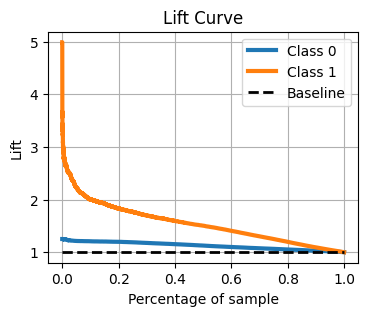

In [48]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('03_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [49]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [50]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('03_REPORT_importance_gain.csv'), index=True)

In [51]:
feat_impgain.head()

,importance
urban_flag,655.424133
LowDoc,106.192345
DisbursementGross,61.139202
new_business,26.279516
CreateJob,16.775785


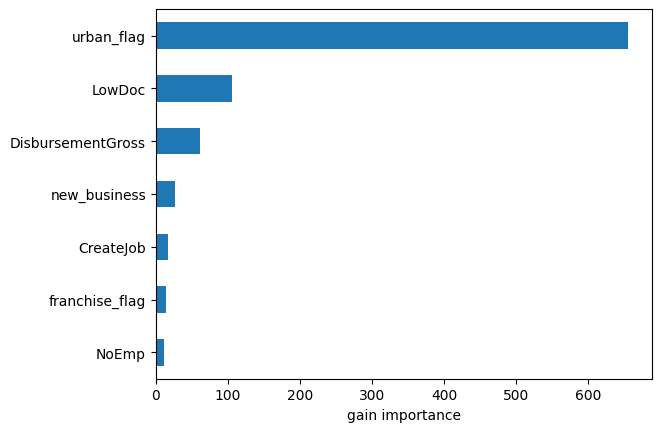

In [52]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('03_PLOT_importance_gain.png'))

##### Permutation Importance

In [53]:
perm_importance = permutation_importance(xgb_model, train_df[predictor_features].reset_index(drop=True), 
                                         train_df['target'].reset_index(drop=True),
                                         n_repeats=30, scoring = 'average_precision')

In [54]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [55]:
perm_importance_df.head(5)

,features,importance,abs_importance
3,DisbursementGross,0.091096,0.091096
5,urban_flag,0.045831,0.045831
1,CreateJob,0.032726,0.032726
2,LowDoc,0.015075,0.015075
0,NoEmp,0.012887,0.012887


In [56]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('03_DATA_importance_perturb.csv'),
            index=False)

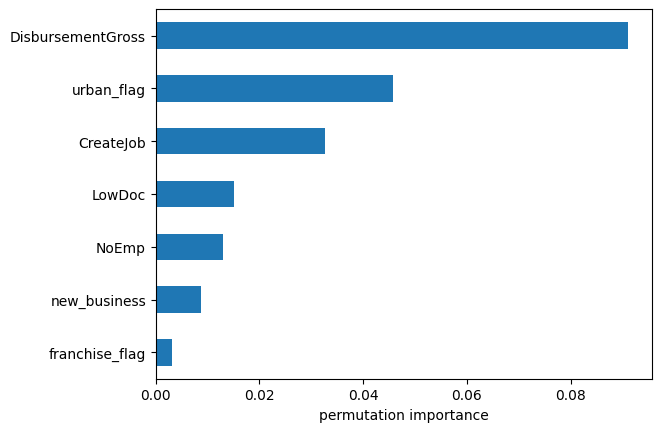

In [57]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('03_PLOT_importance_perturb.png'))